# Clasificación de Sentimientos con Scikit-Learn y MLflow

En este notebook se desarrolla un flujo completo de Machine Learning utilizando un dataset de texto.

**Objetivo principal:**
- Descargar y explorar el dataset SST-2 (Stanford Sentiment Treebank).
- Realizar el preprocesamiento de texto mediante tokenización y vectorización.
- Entrenar un modelo de clasificación con Scikit-Learn.
- Evaluar el rendimiento del modelo con métricas estándar.
- Registrar parámetros, métricas y el modelo en MLflow.
- Preparar scripts `.py` para permitir reproducir los experimentos de forma modular.

Este enfoque está diseñado siguiendo buenas prácticas de reproducibilidad y documentación.


In [1]:
from datasets import load_dataset

# Cargar SST-2 desde la colección GLUE
dataset = load_dataset("glue", "sst2")

# Mostrar las keys del dataset
print("Conjuntos disponibles:", dataset.keys())

# Mostrar un ejemplo
print("Primer ejemplo del set de entrenamiento:")
print(dataset["train"][0])


c:\Users\dario.tomatis\AppData\Local\anaconda3\envs\sst2_mlflow_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\dario.tomatis\AppData\Local\anaconda3\envs\sst2_mlflow_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dario.tomatis\.cache\huggingface\hub\datasets--glue. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to r

Conjuntos disponibles: dict_keys(['train', 'validation', 'test'])
Primer ejemplo del set de entrenamiento:
{'sentence': 'hide new secretions from the parental units ', 'label': 0, 'idx': 0}


In [2]:
import pandas as pd

# Convertir a DataFrame
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["validation"])

# Dimensiones
print("Train shape:", train_df.shape)
print("Validation shape:", test_df.shape)

# Distribución de clases
print("\nDistribución de clases en train:")
print(train_df["label"].value_counts())

# Primeras filas
train_df.head()


Train shape: (67349, 3)
Validation shape: (872, 3)

Distribución de clases en train:
label
1    37569
0    29780
Name: count, dtype: int64


,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


### Exploración del Dataset SST-2

- El conjunto de **entrenamiento** contiene **67,349 ejemplos** y 3 columnas:
  - `sentence`: la frase de entrada.
  - `label`: etiqueta de sentimiento (0 = negativo, 1 = positivo).
  - `idx`: identificador del registro.

- El conjunto de **validación** contiene **872 ejemplos**.

- **Distribución de clases en el set de entrenamiento:**
  - Positivo (`label = 1`): 37,569 ejemplos.
  - Negativo (`label = 0`): 29,780 ejemplos.

- La distribución de clases es relativamente balanceada, con una ligera mayoría de ejemplos positivos.

- A continuación algunos ejemplos de frases:
  - *"hide new secretions from the parental units"* (label 0)
  - *"contains no wit , only labored gags"* (label 0)
  - *"that loves its characters and communicates something rather beautiful about human nature"* (label 1)

Este análisis confirma que el dataset es adecuado para un problema de clasificación binaria.


## Preprocesamiento de Texto

En esta sección realizaremos:

- Conversión de las frases en vectores numéricos mediante **TfidfVectorizer**.
- Creación de las matrices de entrenamiento y prueba que serán utilizadas por el clasificador.

El uso de TF-IDF permite representar cada documento según la relevancia de cada término en el corpus.


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extraemos las listas de textos y etiquetas
train_texts = dataset["train"]["sentence"]
train_labels = dataset["train"]["label"]

test_texts = dataset["validation"]["sentence"]
test_labels = dataset["validation"]["label"]

print("Ejemplo de texto:")
print(train_texts[0])
print("Etiqueta:", train_labels[0])


Ejemplo de texto:
hide new secretions from the parental units 
Etiqueta: 0


In [4]:
# Creamos el vectorizador TF-IDF
vectorizer = TfidfVectorizer(
    max_features=5000,     # Número de términos
    ngram_range=(1,2),     # Unigramas y bigramas
    stop_words="english"   # Eliminamos stopwords en inglés
)

# Ajustamos y transformamos el set de entrenamiento
X_train = vectorizer.fit_transform(train_texts)
y_train = train_labels

# Transformamos el set de validación
X_test = vectorizer.transform(test_texts)
y_test = test_labels

print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)


Forma de X_train: (67349, 5000)
Forma de X_test: (872, 5000)


### Resultados del Preprocesamiento

- Cada frase se convirtió en un vector de longitud **5000**, correspondiente a los términos seleccionados.
- Se consideraron **unigramas y bigramas**, eliminando stopwords.
- Estas matrices están listas para ser utilizadas en el entrenamiento del modelo.


## Entrenamiento y Evaluación del Modelo

En esta sección:

- Entrenaremos un clasificador **Logistic Regression** sobre las representaciones TF-IDF.
- Evaluaremos el rendimiento del modelo con métricas estándar: *accuracy*, *precision*, *recall*.


In [5]:
from sklearn.linear_model import LogisticRegression

# Inicializamos el modelo
clf = LogisticRegression(max_iter=1000)

# Entrenamos con los datos de entrenamiento
clf.fit(X_train, y_train)

# Predicciones sobre el set de validación
y_pred = clf.predict(X_test)


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Reporte detallado
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7810
Precision: 0.7485
Recall: 0.8581

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       428
           1       0.75      0.86      0.80       444

    accuracy                           0.78       872
   macro avg       0.79      0.78      0.78       872
weighted avg       0.79      0.78      0.78       872



### Resultados del Modelo

- **Accuracy:** 0.7810  
  El modelo clasifica correctamente el ~78% de los ejemplos del set de validación.

- **Precision:** 0.7485  
  Entre todas las predicciones positivas, aproximadamente el 75% son correctas.

- **Recall:** 0.8581  
  El modelo identifica correctamente el 86% de los ejemplos que son realmente positivos.

- **Detalle por clase:**
  - Clase **0 (negativo):**
    - Precision: 0.83
    - Recall: 0.70
    - F1-score: 0.76
  - Clase **1 (positivo):**
    - Precision: 0.75
    - Recall: 0.86
    - F1-score: 0.80

- **Observaciones:**
  - El modelo tiende a recuperar más ejemplos positivos (alto recall en clase 1) pero con cierta pérdida de precisión.
  - La precisión es mayor en la clase negativa.
  - El balance entre precisión y recall sugiere que el modelo prioriza no dejar positivos sin detectar.

Estos resultados son coherentes con un clasificador de baseline en problemas de sentimiento.


## Entrenamiento con Random Forest

En este apartado entrenaremos un **Random Forest Classifier** como alternativa para comparar el rendimiento con Logistic Regression.


In [8]:
from sklearn.ensemble import RandomForestClassifier

# Inicializar Random Forest con hiperparámetros base
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Entrenar
rf_clf.fit(X_train, y_train)

# Predecir
y_pred_rf = rf_clf.predict(X_test)

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

print(f"Accuracy (Random Forest): {accuracy_rf:.4f}")
print(f"Precision (Random Forest): {precision_rf:.4f}")
print(f"Recall (Random Forest): {recall_rf:.4f}")

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))


Accuracy (Random Forest): 0.7489
Precision (Random Forest): 0.7389
Recall (Random Forest): 0.7838

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.76      0.71      0.74       428
           1       0.74      0.78      0.76       444

    accuracy                           0.75       872
   macro avg       0.75      0.75      0.75       872
weighted avg       0.75      0.75      0.75       872



### Resultados del Modelo Random Forest

- **Accuracy:** 0.7489  
  El modelo clasifica correctamente aproximadamente el 75% de los ejemplos del set de validación.

- **Precision:** 0.7389  
  De todas las predicciones positivas realizadas, alrededor del 74% fueron correctas.

- **Recall:** 0.7838  
  El modelo identificó correctamente el 78% de los ejemplos positivos.

- **Detalle por clase:**
  - Clase **0 (negativo):**
    - Precision: 0.76
    - Recall: 0.71
    - F1-score: 0.74
  - Clase **1 (positivo):**
    - Precision: 0.74
    - Recall: 0.78
    - F1-score: 0.76

- **Observaciones:**
  - El Random Forest obtuvo un rendimiento ligeramente inferior en accuracy respecto a la Regresión Logística.
  - El balance entre precisión y recall es similar entre ambas clases.
  - Este modelo podría beneficiarse de un ajuste de hiperparámetros (por ejemplo, `max_depth`, `min_samples_leaf`) para mejorar su rendimiento.


## Ajuste de Hiperparámetros en Logistic Regression

En este apartado probaremos cambiar el hiperparámetro **C** (inversa de la regularización) en la regresión logística.  
Valores más bajos de **C** implican una regularización más fuerte y pueden ayudar a reducir el sobreajuste.


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Inicializar Logistic Regression con C=0.5
clf_tuned = LogisticRegression(max_iter=1000, C=0.5)

# Entrenar
clf_tuned.fit(X_train, y_train)

# Predecir
y_pred_tuned = clf_tuned.predict(X_test)

# Métricas
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)

print(f"Accuracy (Logistic Regression C=0.5): {accuracy_tuned:.4f}")
print(f"Precision (C=0.5): {precision_tuned:.4f}")
print(f"Recall (C=0.5): {recall_tuned:.4f}")

print("\nClassification Report (C=0.5):")
print(classification_report(y_test, y_pred_tuned))


Accuracy (Logistic Regression C=0.5): 0.7867
Precision (C=0.5): 0.7500
Recall (C=0.5): 0.8716

Classification Report (C=0.5):
              precision    recall  f1-score   support

           0       0.84      0.70      0.76       428
           1       0.75      0.87      0.81       444

    accuracy                           0.79       872
   macro avg       0.79      0.79      0.78       872
weighted avg       0.79      0.79      0.78       872



### Resultados del Logistic Regression con C=0.5

- **Accuracy:** 0.7867  
  El modelo clasifica correctamente aproximadamente el 79% de los ejemplos de validación.

- **Precision:** 0.7500  
  El 75% de las predicciones positivas fueron correctas.

- **Recall:** 0.8716  
  El modelo identificó correctamente el 87% de los ejemplos positivos.

- **Detalle por clase:**
  - Clase **0 (negativo):**
    - Precision: 0.84
    - Recall: 0.70
    - F1-score: 0.76
  - Clase **1 (positivo):**
    - Precision: 0.75
    - Recall: 0.87
    - F1-score: 0.81

- **Observaciones:**
  - Con C=0.5, el modelo aumentó ligeramente el recall en la clase positiva respecto al modelo base.
  - La precisión se mantiene similar.
  - Este ajuste muestra que la regularización influye en el equilibrio entre recall y precisión.


## Matriz de Confusión

La matriz de confusión permite observar en detalle cuántos ejemplos de cada clase fueron correctamente clasificados y cuántos se confundieron con la clase opuesta.


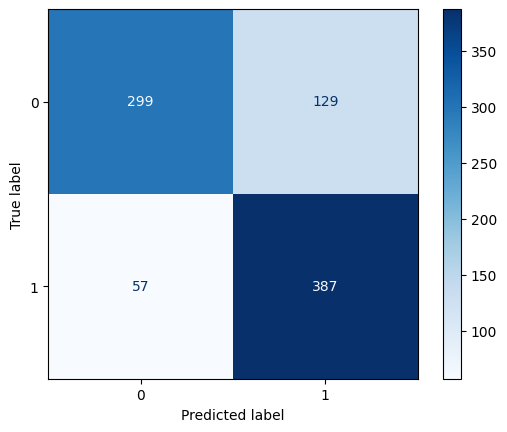

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred_tuned)

# Mostrar
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_tuned.classes_)
disp.plot(cmap="Blues")


### Interpretación de la Matriz de Confusión

- **Clase 0 (Negativo):**
  - Verdaderos Negativos (Predijo 0 y era 0): **299**
  - Falsos Positivos (Predijo 1 y era 0): **129**

- **Clase 1 (Positivo):**
  - Falsos Negativos (Predijo 0 y era 1): **57**
  - Verdaderos Positivos (Predijo 1 y era 1): **387**

**Observaciones:**
- El modelo clasifica correctamente la mayoría de ejemplos positivos (387) y negativos (299).
- El número de falsos positivos (129) es superior al de falsos negativos (57), lo que sugiere que el modelo tiende ligeramente a predecir la clase positiva.
- Esta tendencia se refleja en el recall elevado en la clase 1 y una precisión moderada.

La matriz confirma el comportamiento observado en las métricas de precisión y recall.


## Registro con MLflow

En este bloque configuraremos MLflow para:
- Registrar hiperparámetros.
- Guardar métricas de rendimiento.
- Almacenar el modelo entrenado.

Esto permite reproducir y comparar experimentos de forma estructurada.


In [11]:
import mlflow
import mlflow.sklearn

# Configuramos el nombre del experimento
mlflow.set_experiment("SST2_LogisticRegression")

# Iniciamos un run
with mlflow.start_run(run_name="logreg_c_0.5"):
    # Log de parámetros
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("C", 0.5)
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("vectorizer", "Tfidf (max_features=5000, ngram_range=(1,2))")

    # Log de métricas
    mlflow.log_metric("accuracy", accuracy_tuned)
    mlflow.log_metric("precision", precision_tuned)
    mlflow.log_metric("recall", recall_tuned)

    # Log del modelo
    mlflow.sklearn.log_model(clf_tuned, "model")

print("Registro completado.")


2025/07/03 17:44:26 INFO mlflow.tracking.fluent: Experiment with name 'SST2_LogisticRegression' does not exist. Creating a new experiment.
2025/07/03 17:44:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/03 17:44:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Registro completado.


## Registro de Experimentos en MLflow

A continuación se presentan capturas de la interfaz de MLflow que evidencian el proceso de registro de experimentos, métricas y artefactos del modelo entrenado.

### 1️⃣ Detalle del Run
La primera imagen muestra la vista general del run `logreg_c_0.5`, incluyendo:
- Fecha de creación
- Estado de ejecución
- Usuario que ejecutó el experimento
- Identificadores únicos
- Tiempo de duración

![Detalle Run](images/MLFlow1.jpg)

---

### 2️⃣ Métricas y Parámetros Registrados
La segunda imagen refleja las métricas registradas:
- **Accuracy**
- **Precision**
- **Recall**

Y los hiperparámetros utilizados:
- Modelo: LogisticRegression
- C: 0.5
- max_iter: 1000
- Vectorizer configurado con TFIDF

![Métricas y Parámetros](images/MLFlow2.jpg)

---

### 3️⃣ Modelos Logueados
Esta imagen muestra que el modelo fue almacenado como artefacto en MLflow y está disponible para descarga o reutilización.

![Modelos Logueados](images/MLFlow3.jpg)

---

### 4️⃣ Visualización Gráfica de Métricas
Aquí se observan los gráficos de barra de cada métrica registrada, facilitando su interpretación visual.

![Gráficos de Métricas](images/MLFlow4.jpg)

---

### 5️⃣ Artefactos del Modelo
La última imagen detalla los archivos guardados del modelo, incluyendo:
- `MLmodel` (metadata)
- `model.pkl` (el modelo serializado)
- `conda.yaml` y `python_env.yaml` (dependencias)
- `requirements.txt`

![Artefactos del Modelo](images/MLFlow5.jpg)

